# Genetic Algorithm

In [11]:
%matplotlib notebook
import numpy as np
from random import sample, shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.animation import FuncAnimation
import math

## Introduction
Genetic algorithms are inspired by the theory of evolution, they work on the assumption of <i>transmission of good genes</i>.<br>
Given an optimization problem with solution space $X$ and objective function $f(x)$: 
 * Initialize the population $P_0 \subset X$.
 * Iterate evolution:
     * Selection: choose parents in $P_i$ (based on $f(x)$).
     * Generate oﬀspring with genetic operators.
     * Replacement: produce new population $P_{i+1}$.

The ﬁnal result of the process is often an approximation of the optimal solution: $\underset{x\in X}{argmax}\ f(x) \approx \underset{x\in P_i}{argmax}\ f(x)$.
***
A <b>population</b> is a set of chromosomes, a <b>chromosome</b> is a structure to encode an object in $X$, it is composed of <b>genes</b>.<br>
In this notebook the genetic algorithm will be applied to the Travelling Salesman Problem which, given a list of cities and the distances between them, tries to find the shortest possible route visiting all of them.<br>
In the example, cities have been disposed in a circle in order to better visualize the optimal solution.

<IPython.core.display.Javascript object>


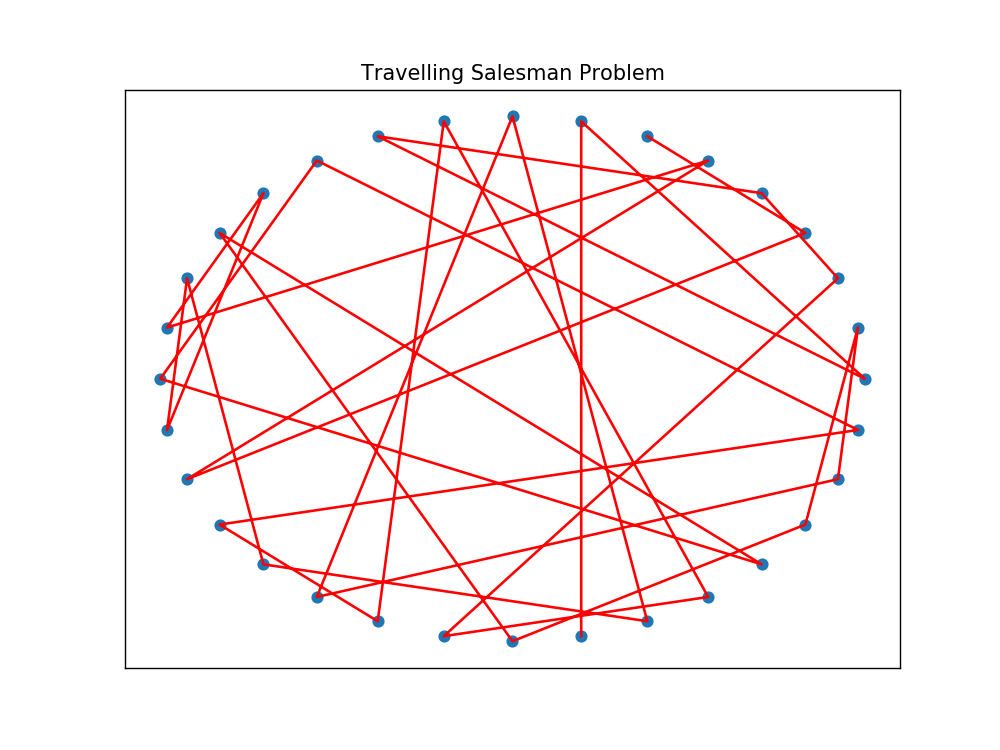

In [12]:
# create input data for the problem: cities, distances and population
n_genes = 32
n_chromosomes = 300
radius = 40

cities = ([(math.cos(2*math.pi/n_genes*x)*radius,math.sin(2*math.pi/n_genes*x)*radius) for x in range(0,n_genes)])
distances = pairwise_distances(cities, metric='euclidean')

def getPopulation(n_genes, n_chromosomes):
    """
    Generate a population of n_chromosomes different permutations of n_genes.
    """
    population = []
    n = 0
    while n < n_chromosomes:
        chromosome = np.random.permutation(n_genes)
        if not any([np.array_equal(chromosome, x) for x in population]):
            population.append(chromosome)
            n += 1
    return population

plotdata = list(cities)
shuffle(plotdata)
plt.figure(figsize=(8,6))
plt.scatter([x[0] for x in plotdata], [x[1] for x in plotdata])
plt.plot([x[0] for x in plotdata], [x[1] for x in plotdata], "r-")
plt.tick_params(bottom='off',
                top='off',
                left='off',
                right='off',
                labelbottom='off',
                labelleft='off')
plt.title("Travelling Salesman Problem")
plt.show()

For this problem the objective function corresponds to the length of the path, therefore it is needed to minimize the fitness defined as follows:

In [13]:
def fitness(chromosome):
    """
    Sum distances between cities corresponding to genes in chromosome.
    """
    
    fitness = 0
    global distances
    
    for i in range(len(chromosome) - 1):
        fitness += distances[chromosome[i]][chromosome[i+1]]
    return fitness

## Selection
The process of choosing chromosomes based on their ﬁtness (objective function) is called selection. It can be used for both the choice of parents in the initial selection and the choice of oﬀsprings in the final replacement.
### Deterministic selection
The idea is to keep the best $k$ chromosomes, this way the process is fast but there is no randomness.<br>
To generate $N$ oﬀsprings each parent should generate $N/k$ oﬀsprings, for a complete replacement of the population $k = N$.
### Probabilistic selection
Select the chromosome $x$ with probability $p(x)$ based on $f(x)$. Assuming that $f(x)>0$:

$$ p(x) = \dfrac{f(x)}{\underset{y\in P}{\sum}f(y)}$$
#### Roulette Wheel Selection
Split $[0, 1]$ in bins of size $p(x_i)$ for each chromosome and, using a uniform random generator, draw a random number $r$ in the same range. If $r$ lies in bin $i$, select the chromosome $x_i$.
#### Stochastic Universal Sampling
Split $[0, 1]$ in bins of size $p(x_i)$, draw a random number $r$ (uniformly) and select all bins containing $(r+k/N)\ mod\ 1$ for $k = 0, ..., N-1$, where $N$ is the number of chromosomes to select.<br>
The advantage over RWS is the lower variance on the set of selected samples.
***
The problem of probabilistic selection is that $p(x)$ depends on the function scale, by changing it to $h(f(x))$, with $h$ monotonic, an analogous optimization problem can be obtained, but with diﬀerent selection. If $h(f(x))$ is ﬂat then there is low discrimination and almost uniform sampling, if it is sharp there is too much focus and almost no search.
##### Selection pressure
Given the following notation:

$$ \hat{f} = \underset{x\in P}{max}\ f(x),\qquad \bar{f} = \dfrac{1}{\lvert P\rvert}\underset{x\in P}{\sum}f(x),\qquad p_s = \dfrac{\hat{f}}{\bar{f}} $$

$p_s$ is the expected number of selections for the best chromosome (based on the ﬁtness value). If $p_s$ is too high there is premature convergence, local search around the best chromosome; if it is too close to 1 then there is no improvement because all chromosomes are selected without discrimination.<br>
In order to solve this problem, some ﬁtness adjustment can be done. The linear adjustment of $f$ can be done as follows:

$$p(x) = \dfrac{af(x) + b}{a\underset{y\in P}{\sum}f(y) + b}$$

Any value of $p_s$ can be achieved by adjusting $a$ and $b$. Other possible adjustment formulas are: exponential ($f^k$) and Boltzmann ($e^{f/T}$, reduce Temperature $T$ with iterations).
***

In [14]:
def probabilisticSelection(population, selection_factor, RWS=False, p=[1, 0]):
    """
    The default method is Stochastic Universal Sampling, if RWS is True, then use Roulette Wheel Selection.
    The p values are used for selection pressure using a linear fitness adjustment.
    """       

    total_fitness = sum([fitness(x) for x in population])
    population = [[x, (p[0]*(total_fitness - fitness(x))+p[1])/(p[0]*(total_fitness*(len(population)-1))+p[1])] for x in population]
    population.sort(key=lambda x: x[1])
    population = [[x[0], y] for x, y in zip(population, np.cumsum([x[1] for x in population]))]

    new_population = []

    if RWS:
        for r in np.random.rand(selection_factor):
            selected_chromosome = [x for x in population if x[1] >= r][0]
            new_population.append(selected_chromosome[0])
    else:
        r = np.random.rand()
        for i in range(selection_factor):
            selected_chromosome = [x for x in population if x[1] >= (r + i/selection_factor)%1][0]
            new_population.append(selected_chromosome[0])

    return new_population

#### Selection by ranking
Order $P$ by decreasing $f$: $f(x_0)\geq f(x_1)\geq ...\geq f(x_{n-1})$, and select with probability based on rank:

$$p(x_i) = \lambda\left(1-\dfrac{i}{n}\right)^k$$

In this case selection pressure depends on $k$, as it grows (> 1) the focus on the ﬁrst chromosome grows, while, as it decreases (< 1), there is less discrimination.
#### Tournament selection
Select $k$ (often 2) random chromosomes, keep the best one and iterate until the desired number of selections is reached.<br>
To modify selection pressure, the probability that the best chromosome is among the $k$ selected is: $p = 1-(\frac{n-1}{n})^k \approx \frac{k}{n}$. So the expected number of selections of the best chromosome after $n$ tournaments is $p_s = k$, pressure increases with $k$.<br>
<br>
A possible alternative is the <b>stochastic tournament selection</b>: select 2 chromosomes at random and keep the best one with ﬁxed probability $q \in [0.5,1]$. The probability to select the best chromosome is approximately $2/N$ and the probability that he wins is $2q/N$ therefore the selection pressure is $p_s = 2q$.

In [15]:
def tournamentSelection(population, selection_factor, k=2, p=0):
    """
    Select k random chromosomes, keep the best one (highest ﬁtness function) and iterate for n=selection_factor times.
    If p != 0 and k == 2 then stochastic tournament selection is applied with probability p of getting the best chromosome.
    """
    
    new_population = []

    if p != 0 and k == 2:
        for i in range(selection_factor):
            s = sample(population, k)
            if np.random.rand() < p:
                new_population.append(min([[x, fitness(x)] for x in s], key=lambda x: x[1])[0])
            else:
                new_population.append(max([[x, fitness(x)] for x in s], key=lambda x: x[1])[0])
    else:
        for i in range(selection_factor):
            s = sample(population, k)
            new_population.append(min([[x, fitness(x)] for x in s], key=lambda x: x[1])[0])

    return new_population

## Genetic Operators
Genetic operators generate oﬀsprings from parents, there can be many variations and they often include some randomness.
### Mutation
Mutations randomly invert bits (genes) with probability $p_m$ (typically very small 0.1 - 0.01). Mutations ensure that every chromosome can be transformed into any other with nonzero probability.
### Crossover
Crossover is used for “coupling”, it splits and mixes the chromosomes. There are 3 main types:
 * 1 point crossover, choose a random split location.
 * 2 points crossover, choose a random segment to switch.
 * random crossover, random choice for each bit.
***
It is considered good to have both crossover and mutations because each has its own role: crossover is explorative (it makes big jumps in the solution space) and mutation is exploitative (it creates small diversions). Only crossover can combine the information of two parents while only mutation can introduce new information. In soome cases $f(x)$ is not deﬁned everywhere so we need to check the operator result (partially deﬁned operator).<br>
<br>
In this particular problem there can't be duplicate genes in a chromosome, this would mean passing two times from a city while skipping another one, therefore both crossover and mutation have to be implemented carefully.

In [16]:
def crossover(parent1, parent2):
    """
    Produces offsprings of parent1 and parent2 by using two points crossover.
    """
    
    n_genes = len(parent1)
    cross_point1, cross_point2 = sample(range(n_genes), 2)
    if (cross_point1 > cross_point2):
        tmp = cross_point1
        cross_point1 = cross_point2
        cross_point2 = tmp

    child1 = np.array(parent1)
    child2 = np.array(parent2)
    j1 = cross_point1
    j2 = cross_point2
    for i in range(cross_point1, cross_point2):
        while parent2[j1] not in parent1[cross_point1:cross_point2]:
            j1 = (j1+1)%n_genes
        child1[i] = parent2[j1]
        j1 = (j1+1)%n_genes

        while parent1[j2] not in parent2[cross_point1:cross_point2]:
            j2 = (j2+1)%n_genes
        child2[i] = parent1[j2]
        j2 = (j2+1)%n_genes

    return child1, child2#np.array(child1), np.array(child2)

def mutation(chromosome):
    """
    Switch two random genes of the chromosome.
    """
    
    mutated = np.array(chromosome)
    gene1, gene2 = sample(range(len(chromosome)), 2)
    mutated[gene1] = chromosome[gene2]
    mutated[gene2] = chromosome[gene1]
    return mutated

def createOffspring(parents, p=0.1):
    """
    Apply crossover and mutation to the parents.
    p is the probability to have mutations.
    """
    offspring = []

    for i in range(len(parents)):
        p1, p2 = sample(parents, 2)
        c1, c2 = crossover(p1, p2)
        if (not any([np.array_equal(c1, x) for x in parents]) and 
            not any([np.array_equal(c1, x) for x in offspring])):
            offspring.append(c1)
        if (not any([np.array_equal(c2, x) for x in parents]) and 
            not any([np.array_equal(c2, x) for x in offspring])):
            offspring.append(c2)

    for x in parents:
        if np.random.rand() <= p:
            c = mutation(x)
            if (not any([np.array_equal(c, x) for x in parents]) and 
                not any([np.array_equal(c, x) for x in offspring])):
                offspring.append(c)

    return offspring

## Replacement strategies
There are many variations of genetic evolution depending on the type and combinations of the selection and the operators. A general principle is to keep the population $P$ of ﬁxed size, parents may survive or die. There are diﬀerent replacement strategies:
 * Global replacement. The new population is composed of all oﬀsprings (good parents could die). We can either generate exactly $N$ oﬀsprings or generate $M > N$ oﬀsprings and keep the $N$ best.
 * Steady state replacement. Generate a small number of oﬀsprings and replace only some parents (random or worst).
 * Elitism. Keep $k$ best parents and add new oﬀsprings.
 
In some cases the neighbours of the optimum have poor performance and are likely to disappear. There could be no possible crossover to generate the optimum from the neighbours and it is very unlikely to be generated by mutations. When small variations in the value cause large variations in the bit string (Hamming cliﬀ problem), a possible solution is to use Gray coding so that mutations can generate close values (short Hamming distance).

In [17]:
def elitismReplacement(population, offspring, n_elite):
    """
    Keep the n=n_elite best parents and substitute the others with the best offsprings
    without changing the number of chromosomes.
    """
    population.sort(key=lambda x: fitness(x))
    new_population = population[:n_elite]
    offspring.sort(key=lambda x: fitness(x))
    new_population.extend(offspring[:(len(population) - n_elite)])
    return new_population

In [25]:
import matplotlib.animation as animation

def update(i, line, ax):
    global population
    parents = probabilisticSelection(population, 150)
    offspring = createOffspring(parents)
    population = elitismReplacement(population, offspring, 100)

    best = min(population, key=lambda x: fitness(x))
    plotdata = [cities[x] for x in best]

    ax.set_title('iteration #{i}: {d}'.format(i=i, d=fitness(best)))
    line.set_data([x[0] for x in plotdata], [x[1] for x in plotdata])
    return line

population = getPopulation(n_genes, n_chromosomes)

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
line, = ax.plot([], [], 'r-')
ax.set_xlim(-(radius+10), (radius+10))
ax.set_ylim(-(radius+10), (radius+10))
ax.grid(True)
ax.scatter([x[0] for x in cities], [x[1] for x in cities], c='k')
ax.tick_params(bottom='off',
                top='off',
                left='off',
                right='off',
                labelbottom='off',
                labelleft='off')

Writer = animation.writers['gif']
writer = Writer(fps=15, metadata=dict(artist='GiacomoDeodato'), bitrate=1800)

anim = FuncAnimation(fig, update, frames=np.arange(300), interval=200, blit=True, fargs=(line, ax), repeat=False)



anim.save('lines.html', writer=writer)
plt.show()

<IPython.core.display.Javascript object>

KeyError: 'gif'

In [9]:
"""
def update(i, lines, axes):
    global population
    alg = ['SUS', 'RWS', 'TS']
    for ga in range(3):
        parents = []
        if ga == 0:
            parents = probabilisticSelection(population[ga], 150)
        elif ga == 1:
            parents = probabilisticSelection(population[ga], 150, RWS=True)
        else:
            parents = tournamentSelection(population[ga], 150, p=0.7)
        offspring = createOffspring(parents)
        population[ga] = elitismReplacement(population[ga], offspring, 100)
    
        best = min(population[ga], key=lambda x: fitness(x))
        plotdata = [cities[x] for x in best]
        
        axes[ga].set_title('{a} #{i}: {d}'.format(a=alg[ga], i=i, d=fitness(best)))
        lines[ga].set_data([x[0] for x in plotdata], [x[1] for x in plotdata])
    return lines[0]

population = getPopulation(n_genes, n_chromosomes)
population = [population, population, population]

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12,4)
lines = []
for ax in axes:
    line, = ax.plot([], [], 'r-')
    lines.append(line)
    ax.set_xlim(-(radius+10), (radius+10))
    ax.set_ylim(-(radius+10), (radius+10))
    ax.grid(True)
    ax.scatter([x[0] for x in cities], [x[1] for x in cities], c='k')
    ax.tick_params(bottom='off',
                    top='off',
                    left='off',
                    right='off',
                    labelbottom='off',
                    labelleft='off')

anim = FuncAnimation(fig, update, frames=np.arange(300), interval=200, blit=True, fargs=(lines, axes), repeat=False)
plt.show()
"""

"\ndef update(i, lines, axes):\n    global population\n    alg = ['SUS', 'RWS', 'TS']\n    for ga in range(3):\n        parents = []\n        if ga == 0:\n            parents = probabilisticSelection(population[ga], 150)\n        elif ga == 1:\n            parents = probabilisticSelection(population[ga], 150, RWS=True)\n        else:\n            parents = tournamentSelection(population[ga], 150, p=0.7)\n        offspring = createOffspring(parents)\n        population[ga] = elitismReplacement(population[ga], offspring, 100)\n    \n        best = min(population[ga], key=lambda x: fitness(x))\n        plotdata = [cities[x] for x in best]\n        \n        axes[ga].set_title('{a} #{i}: {d}'.format(a=alg[ga], i=i, d=fitness(best)))\n        lines[ga].set_data([x[0] for x in plotdata], [x[1] for x in plotdata])\n    return lines[0]\n\npopulation = getPopulation(n_genes, n_chromosomes)\npopulation = [population, population, population]\n\nfig, axes = plt.subplots(1, 3)\nfig.set_size_inches(